In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [12]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [15]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [18]:
# Additionally explicitely inspecting both tables
inspector = inspect(engine)

# Inspecting measurement table
measurement_insp=pd.DataFrame(inspector.get_columns("measurement"))
measurement_insp

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


In [19]:
# Inspecting station table
station_insp=pd.DataFrame(inspector.get_columns("station"))
station_insp

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


# Exploratory Climate Analysis

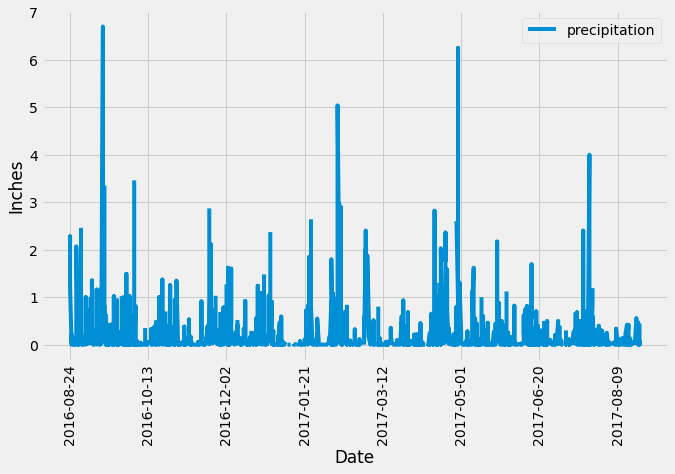

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# then we output actual values

# Calculate the date 1 year ago from the last data point in the database
date_12_mnth_earlier = datetime.strptime(max(session.query(measurement.date))[0], '%Y-%m-%d') - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
# for row in session.query(measurement.id, 
#                          measurement.date, 
#                          measurement.tobs, 
#                          measurement.prcp).filter(measurement.date>=date_12_mnth_earlier):
#     print(row)
    
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_dic = (session.query(measurement.date, measurement.prcp, measurement.station, measurement.tobs).filter(measurement.date>=date_12_mnth_earlier))
climate_df = pd.DataFrame.from_dict(climate_dic)
climate_df= pd.DataFrame(climate_df).set_index('date')

# Sort the dataframe by date
climate_df=climate_df.sort_index()
climate_df

# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
plt.plot(climate_df['prcp'], label='precipitation')
plt.xticks(rotation=90)
# plt.locator_params()
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.tight_layout
plt.savefig("Images/precipitation_own.png")

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(climate_df['prcp'].describe())

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?
station_count_v1 = session.query(station.name).count()
station_count_v1

9

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_dic = (session.query(measurement.station, measurement.tobs))
station_df = pd.DataFrame.from_dict(station_dic)
station_count_v2 = station_df['station'].nunique()
station_count_v2
station_stats=station_df.groupby('station').count().sort_values(by=['tobs'], ascending=False)
station_stats

,tobs
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [49]:
# Extract name of the most active sation
most_active_station=station_stats[station_stats['tobs'] == station_stats['tobs'].max()].index[0]
most_active_station

'USC00519281'

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# -------- Python heavy implementation
station_stats_py = station_stats
station_stats_py = station_stats_py.rename(columns={"tobs":"Obs count"})
station_stats_py['Lowest temp']=station_df.groupby('station').min()
station_stats_py['Average temp']=round(station_df.groupby('station').mean(),2)
station_stats_py['Highest temp']=station_df.groupby('station').max()
pd.DataFrame(station_stats_py.loc[most_active_station])

,USC00519281
Obs count,2772.00
Lowest temp,54.00
Average temp,71.66
Highest temp,85.00


In [68]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# -------- sqlalchemy implementation
station_stats_sql = station_stats
station_stats_sql=station_stats.rename(columns={"tobs":"Obs count"})
station_stats_sql['Lowest temp']=round(session.query(func.min(measurement.tobs)).\
                                                filter(measurement.station == most_active_station).\
                                                all()[0][0],2)
station_stats_sql['Average temp']=round(session.query(func.avg(measurement.tobs)).\
                                                filter(measurement.station == most_active_station).\
                                                all()[0][0],2)
station_stats_sql['Highest temp']=round(session.query(func.max(measurement.tobs)).\
                                                filter(measurement.station == most_active_station).\
                                                all()[0][0], 2)
pd.DataFrame(station_stats_sql.loc[most_active_station])

,USC00519281
Obs count,2772.000000
Lowest temp,54.000000
Average temp,71.663781
Highest temp,85.000000


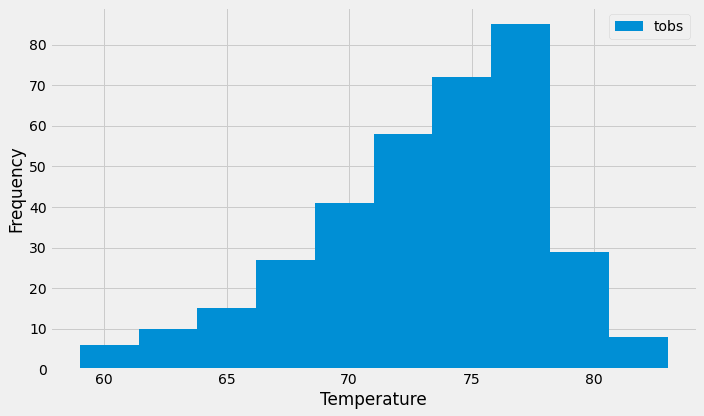

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_USC00519281_data=climate_df[climate_df['station'] == most_active_station]
station_USC00519281_data
plt.figure(figsize=(10,6))
plt.hist(station_USC00519281_data['tobs'], label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig("Images/temperature_own.png")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
